In [29]:
import pickle
import tushare as ts

import os
import numpy as np
import pandas as pd

from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", module="matplotlib")    
warnings.filterwarnings("ignore", module="pandas")    

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
ts.set_token("76e92aefdcac82bf64da67564bd78d8871fcfb5659a48e8a7e779875")
pro = ts.pro_api()

# Q3

In [5]:
基本数据 = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')
股票代码列表 = 基本数据[(基本数据["industry"] == "银行") & (基本数据["list_date"] < '20150101')]["ts_code"].tolist()
股票代码列表 = {int(_code.split(".")[0]): _code for _code in 股票代码列表}

最大股票代码的银行股列表 = []
for _, _code in sorted(股票代码列表.items(), key=lambda x: x[0], reverse=True)[:10]:
    最大股票代码的银行股列表.append(_code)

银行股日线数据 = defaultdict(pd.DataFrame)
for _code in 最大股票代码的银行股列表:
    银行股日线数据[_code] = pro.daily(ts_code=_code, start_date='20150101', end_date='20211231')

In [7]:
银行股日线收盘价数据 = defaultdict(pd.DataFrame)
最大交易日期列表 = []
for _code in 银行股日线数据:
    银行股日线收盘价数据[_code] = 银行股日线数据[_code].copy()
    银行股日线收盘价数据[_code] = 银行股日线收盘价数据[_code].get(["trade_date", "close"])
    银行股日线收盘价数据[_code].rename(columns={"close": _code}, inplace=True)
    银行股日线收盘价数据[_code].set_index("trade_date", inplace=True)
    if 银行股日线收盘价数据[_code].shape[0] > len(最大交易日期列表): 
        最大交易日期列表 = 银行股日线收盘价数据[_code].index.tolist()

# 合并数据
合并后的银行股收盘价数据 = pd.DataFrame(columns=list(银行股日线数据.keys()), index=最大交易日期列表[::-1])
for _trade_date, row in 合并后的银行股收盘价数据.iterrows():
    for _code in row.keys():
        if _trade_date in 银行股日线收盘价数据[_code].index:
            row[_code] = 银行股日线收盘价数据[_code].loc[_trade_date].values[0]

L = 合并后的银行股收盘价数据.shape[0]
for _code in 合并后的银行股收盘价数据.keys():
    if pd.isnull(合并后的银行股收盘价数据[_code]).any(): # 处理nan值
        for _id in range(L):
            if _id > 0 and pd.isnull(合并后的银行股收盘价数据[_code].iloc[_id]):
                合并后的银行股收盘价数据[_code].iloc[_id] = 合并后的银行股收盘价数据[_code].iloc[_id-1]

In [8]:
# 计算10支股票收益率序列
股票收益率序列 = 合并后的银行股收盘价数据.pct_change(1)
股票收益率序列 = 股票收益率序列.dropna()
股票收益率序列

,601998.SH,601988.SH,601939.SH,601818.SH,601398.SH,601328.SH,601288.SH,601169.SH,601166.SH,601009.SH
20150106,-0.028186,0.031674,-0.014451,-0.018293,0.007905,-0.021277,0.015424,-0.019039,0.007113,-0.020394
20150107,-0.002522,-0.004386,-0.027859,-0.014493,-0.011765,-0.020290,-0.015190,-0.020333,-0.022366,-0.013185
20150108,-0.046776,-0.046256,-0.042232,-0.044118,-0.041667,-0.034024,-0.041131,-0.032075,-0.042143,-0.036568
20150109,0.007958,0.032333,0.007874,0.010989,0.010352,-0.004594,0.008043,0.044834,0.016970,0.010949
20150112,-0.018421,-0.015660,-0.023438,-0.017391,-0.012295,-0.003077,-0.023936,0.020522,-0.009271,-0.026715
...,...,...,...,...,...,...,...,...,...,...
20211227,-0.004338,0.003279,-0.006768,0.003012,0.002151,0.004396,0.000000,0.000000,-0.011536,-0.010090
20211228,0.006536,0.003268,0.006814,0.000000,0.004292,0.002188,0.003401,0.006787,0.010080,0.010193
20211229,0.002165,-0.006515,-0.006768,-0.003003,-0.004274,0.002183,-0.003390,0.002247,-0.006303,-0.003363
20211230,-0.004320,0.000000,0.000000,0.000000,-0.004292,0.002179,0.000000,-0.002242,0.006871,0.004499


In [9]:
# 计算相关矩阵
股票相关矩阵 = 股票收益率序列.corr()
股票相关矩阵

,601998.SH,601988.SH,601939.SH,601818.SH,601398.SH,601328.SH,601288.SH,601169.SH,601166.SH,601009.SH
601998.SH,1.000000,0.750981,0.709620,0.753185,0.659264,0.715438,0.704921,0.572542,0.657623,0.517517
601988.SH,0.750981,1.000000,0.790890,0.757245,0.794688,0.780075,0.821418,0.575869,0.636854,0.478922
601939.SH,0.709620,0.790890,1.000000,0.761937,0.838592,0.761662,0.831302,0.579575,0.710989,0.562876
601818.SH,0.753185,0.757245,0.761937,1.000000,0.708452,0.794767,0.749235,0.614211,0.743768,0.558669
601398.SH,0.659264,0.794688,0.838592,0.708452,1.000000,0.742598,0.832765,0.543338,0.655199,0.492340
601328.SH,0.715438,0.780075,0.761662,0.794767,0.742598,1.000000,0.770855,0.634117,0.692786,0.524968
601288.SH,0.704921,0.821418,0.831302,0.749235,0.832765,0.770855,1.000000,0.569986,0.672466,0.503354
601169.SH,0.572542,0.575869,0.579575,0.614211,0.543338,0.634117,0.569986,1.000000,0.625880,0.494002
601166.SH,0.657623,0.636854,0.710989,0.743768,0.655199,0.692786,0.672466,0.625880,1.000000,0.598144
601009.SH,0.517517,0.478922,0.562876,0.558669,0.492340,0.524968,0.503354,0.494002,0.598144,1.000000


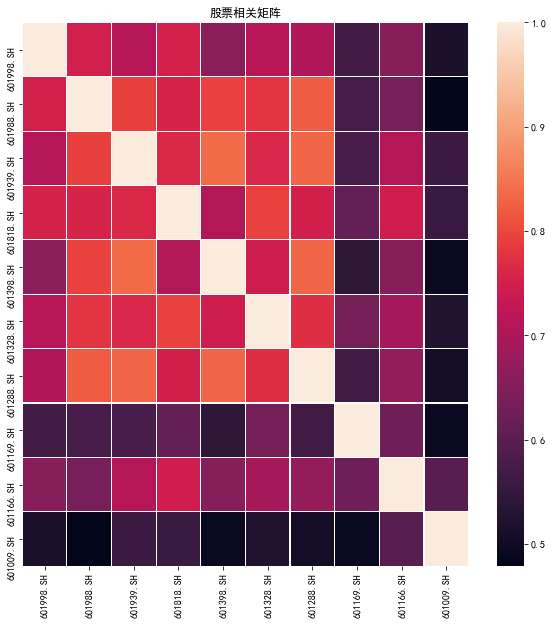

In [13]:
plt.subplots(figsize=(10, 10))
sns.heatmap(股票相关矩阵, linewidths=0.1)
plt.title('股票相关矩阵')
plt.show()

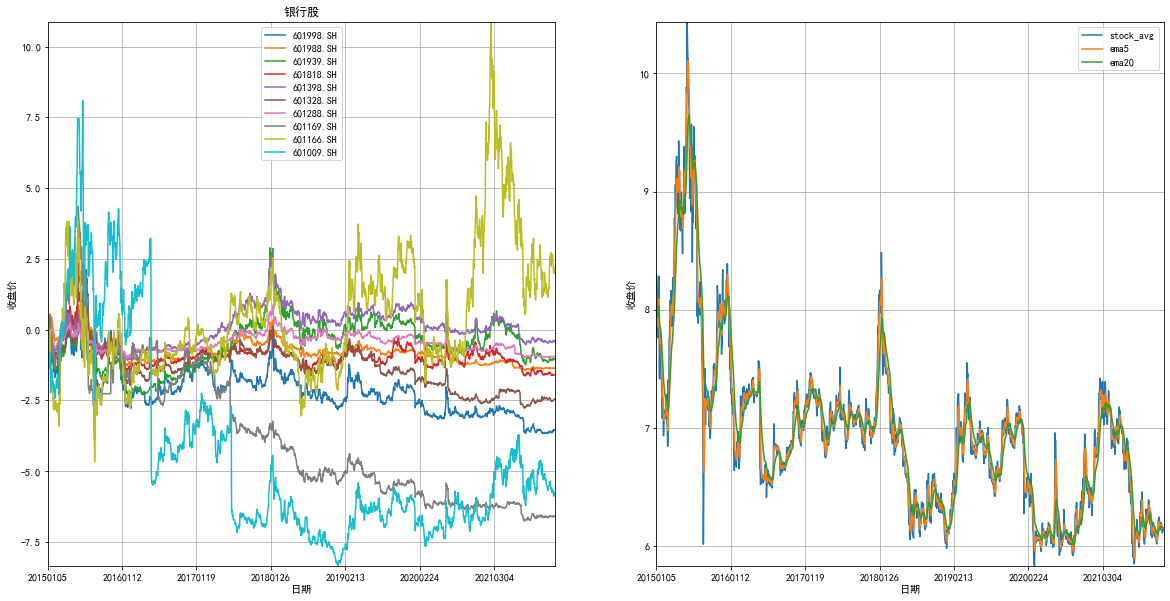

In [15]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,2,1)
ax = (合并后的银行股收盘价数据 - 合并后的银行股收盘价数据.iloc[0]).plot(ax=ax, title="银行股", fontsize=10, grid=True)
ax.set_ylabel("收盘价")
ax.set_xlabel('日期')
plt.margins(0, 0)

ax = fig.add_subplot(1,2,2)
stock_avg = 合并后的银行股收盘价数据.mean(axis=1)  # 计算stock_avg
ema5 = pd.DataFrame.ewm(stock_avg, span=5).mean()  # 计算ema5
ema20 = pd.DataFrame.ewm(stock_avg, span=20).mean()  # 计算ema20

stock_avg.plot(ax=ax, grid=True)
ema5.plot(ax=ax, grid=True)
ema20.plot(ax=ax, grid=True)

ax.fill_between(stock_avg.index, ema5, ema20, color="r", alpha=0.1)
ax.set_ylabel("收盘价")
ax.set_xlabel('日期')
ax.legend(["stock_avg", "ema5", "ema20"])
plt.margins(0, 0)

plt.show()

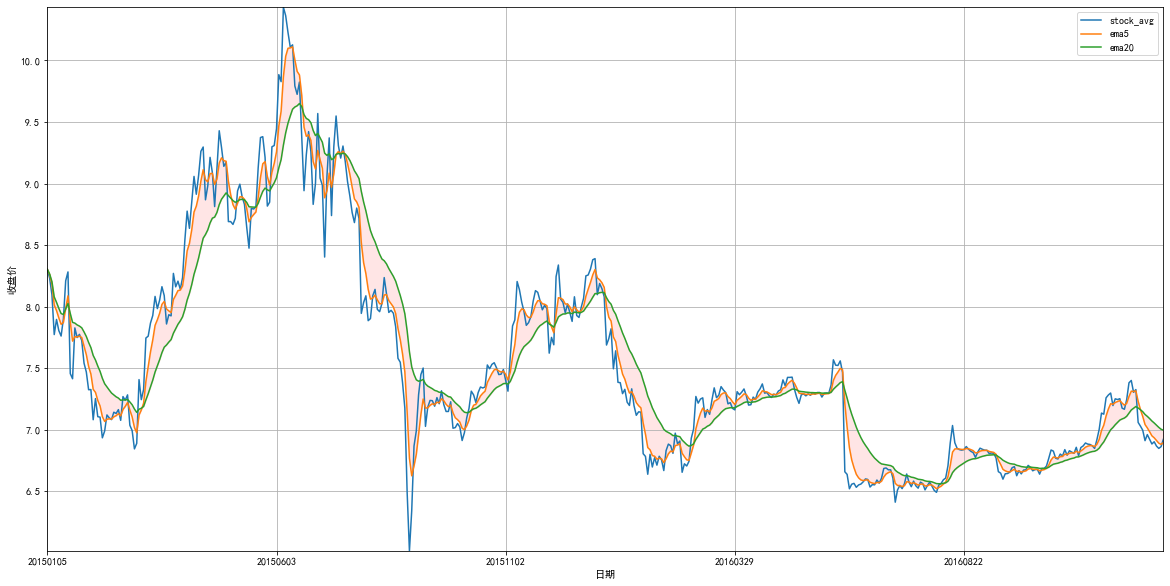

In [25]:
# 选 2015-01-01 至 2016-12-31 进行放大观察细节
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)

stock_avg = 合并后的银行股收盘价数据.mean(axis=1)['20150101':'20161231']  # 计算stock_avg
ema5 = pd.DataFrame.ewm(stock_avg, span=5).mean()  # 计算ema5
ema20 = pd.DataFrame.ewm(stock_avg, span=20).mean()  # 计算ema20

stock_avg.plot(ax=ax, grid=True)
ema5.plot(ax=ax, grid=True)
ema20.plot(ax=ax, grid=True)

ax.fill_between(stock_avg.index, ema5, ema20, color="r", alpha=0.1)
ax.set_ylabel("收盘价")
ax.set_xlabel('日期')
ax.legend(["stock_avg", "ema5", "ema20"])
plt.margins(0, 0)

plt.show()

# Q4

In [45]:
def 计算最大回撤(return_list):
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # 结束位置
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  # 开始位置
    return (return_list[j] - return_list[i]) / (return_list[j])

def 计算夏普比率(x):
    x = x.pct_change(1).cumsum()
    x = (x - x.shift(1)) / x.shift(1)
    return x.mean() / x.std() * np.sqrt(252)

def 计算年平均收益率(x):
    x = x.pct_change(1).mean()
    return ((1 + x)**252) - 1

In [52]:
夏普率_最大回撤_平均收益 = pd.DataFrame(columns=["股票代码", "夏普比率", "最大回撤", "平均收益率"])
夏普率_最大回撤_平均收益["股票代码"] = 合并后的银行股收盘价数据.keys()
for _, a in 夏普率_最大回撤_平均收益.iterrows():
    a["最大回撤"] = 计算最大回撤(合并后的银行股收盘价数据[a["股票代码"]])
    a["夏普比率"] = 计算夏普比率(合并后的银行股收盘价数据[a["股票代码"]])
    a["平均收益率"] = 计算年平均收益率(合并后的银行股收盘价数据[a["股票代码"]])

夏普率_最大回撤_平均收益

,股票代码,夏普比率,最大回撤,平均收益率
0,601998.SH,0.310798,0.56323,-0.0421786
1,601988.SH,0.414004,0.467857,-0.0285991
2,601939.SH,-0.009824,0.420999,0.00983489
3,601818.SH,-0.438105,0.485893,-0.0189352
4,601398.SH,0.311528,0.415484,0.0117871
5,601328.SH,0.0750534,0.544681,-0.0322823
6,601288.SH,-0.304336,0.389474,-0.0188529
7,601169.SH,-0.643157,0.721897,-0.0926398
8,601166.SH,0.424975,0.410628,0.0605417
9,601009.SH,-0.283258,0.720614,0.00906584


In [63]:
print("夏普率和最大回撤率的相关系数：", 夏普率_最大回撤_平均收益['夏普比率'].corr(夏普率_最大回撤_平均收益['最大回撤'], method="spearman"))
print("夏普率和平均收益率的相关系数：", 夏普率_最大回撤_平均收益['夏普比率'].corr(夏普率_最大回撤_平均收益['平均收益率'], method="spearman"))
print("夏普率和平均收益率存在一定的正相关性，而与最大回撤率存在一定的负相关性。")

夏普率和最大回撤率的相关系数： -0.41818181818181815
夏普率和平均收益率的相关系数： 0.41818181818181815
夏普率和平均收益率存在一定的正相关性，而与最大回撤率存在一定的负相关性。


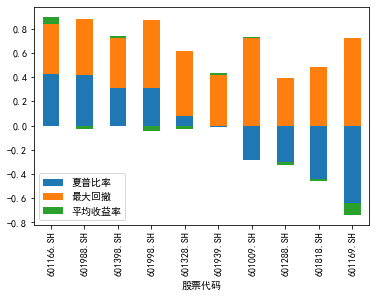

In [62]:
夏普率_最大回撤_平均收益.sort_values(by='夏普比率', inplace=True, ascending=False) 
夏普率_最大回撤_平均收益.plot.bar(x='股票代码', y=['夏普比率', '最大回撤', '平均收益率'], stacked=True)
plt.show()

In [64]:
print("由上面的堆叠柱状图可以看到，'601166.SH'的夏普率和平均收益都是最大的，且最大回撤也是最小的，因此我会选择该支股票进行投资")

由上面的堆叠柱状图可以看到，'601166.SH'的夏普率和平均收益都是最大的，且最大回撤也是最小的，因此我会选择该支股票进行投资
